# Feedforward Neural Networks (FNN)

In [1]:
import math
import pandas as pd
import numpy as np 
import tensorflow as tf
import warnings
import spacy

from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

from tensorflow.keras.utils import to_categorical

import matplotlib.pyplot as plt
import seaborn as sns


warnings.filterwarnings("ignore")
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)

## Load Data

In [2]:
df_train = pd.read_csv('data/train_data.txt', header=None, delimiter=';')
df_test = pd.read_csv('data/test_data.txt', header=None, delimiter=';')

df_train = df_train.rename(columns= {0: 'text', 1: 'feeling'})
df_test = df_test.rename(columns= {0: 'text', 1: 'feeling'})

print(df_train.shape)
print(df_test.shape)

(16000, 2)
(2000, 2)


In [3]:
display(df_train.head(3))
display(df_test.head(3))

,text,feeling
0,i am feeling completely overwhelmed i have two strategies that help me to feel grounded pour my heart out in my journal in the form of a letter to god and then end with a list of five things i am most grateful for,fear
1,i have the feeling she was amused and delighted,joy
2,i was able to help chai lifeline with your support and encouragement is a great feeling and i am so glad you were able to help me,joy


,text,feeling
0,i feel like my only role now would be to tear your sails with my pessimism and discontent,sadness
1,i feel just bcoz a fight we get mad to each other n u wanna make a publicity n let the world knows about our fight,anger
2,i feel like reds and purples are just so rich and kind of perfect,joy


> The column **text** is going to be the input feature and **feeling** is going to be the output target.

In [4]:
df_train['feeling'].value_counts()

feeling
joy         5362
sadness     4666
anger       2159
fear        1937
love        1304
surprise     572
Name: count, dtype: int64

In [5]:
df_test['feeling'].value_counts()

feeling
joy         695
sadness     581
anger       275
fear        224
love        159
surprise     66
Name: count, dtype: int64

## Data preprocessing using Spacy

[Oficial site](https://spacy.io/).

In [6]:
# !python -m spacy download en_core_web_md -q

✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_md')


In [7]:
# Load the dict
spacy_nlp = spacy.load('en_core_web_md')

In [8]:
def data_preprocessing(text):

    doc = spacy_nlp(text)

    tokens = [token.lemma_.lower().strip() for token in doc if not token.is_stop]

    return ' '.join(tokens)

In [9]:
df_train['transformed_text'] = df_train['text'].apply(data_preprocessing)
df_test['transformed_text'] = df_test['text'].apply(data_preprocessing)

In [10]:
display(df_train.head())
display(df_test.head())

,text,feeling,transformed_text
0,i am feeling completely overwhelmed i have two strategies that help me to feel grounded pour my heart out in my journal in the form of a letter to god and then end with a list of five things i am most grateful for,fear,feel completely overwhelmed strategy help feel ground pour heart journal form letter god end list thing grateful
1,i have the feeling she was amused and delighted,joy,feeling amuse delight
2,i was able to help chai lifeline with your support and encouragement is a great feeling and i am so glad you were able to help me,joy,able help chai lifeline support encouragement great feeling glad able help
3,i already feel like i fucked up though because i dont usually eat at all in the morning,anger,feel like fuck not usually eat morning
4,i still love my so and wish the best for him i can no longer tolerate the effect that bm has on our lives and the fact that is has turned my so into a bitter angry person who is not always particularly kind to the people around him when he is feeling stressed,sadness,love wish good long tolerate effect bm life fact turn bitter angry person particularly kind people feel stress


,text,feeling,transformed_text
0,i feel like my only role now would be to tear your sails with my pessimism and discontent,sadness,feel like role tear sail pessimism discontent
1,i feel just bcoz a fight we get mad to each other n u wanna make a publicity n let the world knows about our fight,anger,feel bcoz fight mad n u wanna publicity n let world know fight
2,i feel like reds and purples are just so rich and kind of perfect,joy,feel like red purple rich kind perfect
3,im not sure the feeling of loss will ever go away but it may dull to a sweet feeling of nostalgia at what i shared in this life with my dad and the luck i had to have a dad for years,sadness,m sure feeling loss away dull sweet feeling nostalgia share life dad luck dad year
4,i feel like ive gotten to know many of you through comments and emails and for that im appreciative and glad you are a part of this little space,joy,feel like ve get know comment email m appreciative glad little space


## Building the model

### 1) TF-IDF Vectorizer

Here is the English translation:

This line above creates an instance of the **TfidfVectorizer** from the scikit-learn library, which is a tool used to convert a collection of raw documents into a TF-IDF (Term Frequency-Inverse Document Frequency) feature matrix. TF-IDF is a statistical technique used to quantify the importance of a word in a set of documents, commonly employed in natural language processing tasks and information retrieval.

**Parameter max_df=0.95**: This parameter defines the maximum document frequency threshold for the terms to be considered. Here, it's set to 0.95, meaning that words appearing in more than 95% of the documents will be ignored. This helps eliminate common words that do not contribute much to the meaning of the text.

**Parameter min_df=2**: This parameter establishes the minimum document frequency for the terms. In this case, terms that appear in fewer than two documents will be ignored. This helps filter out rare terms that may occur in only a few samples and are, therefore, less relevant to the overall analysis.

**Parameter stop_words='english'**: This parameter instructs the vectorizer to remove all English stop words from the analysis. Stop words are common words (such as "and," "the," "in") that are usually filtered out in natural language processing because they are very frequent and do not carry significant information for text analysis.

In [11]:
# Defining the vectorizer
tf_idf = TfidfVectorizer(max_df=0.95, min_df=2, stop_words='english')

df_train_tfidf = tf_idf.fit_transform(df_train['transformed_text'])
df_test_tfidf = tf_idf.transform(df_test['transformed_text'])

In [12]:
# Coverting the input data to array 
X_train_array = df_train_tfidf.toarray()
X_test_array = df_test_tfidf.toarray()

### 2) Data preparation

We need to convert the target variable for numerical representation. We will use Label Encoding.

In [13]:
# Defining the Label encoder
le = LabelEncoder()

# Doing the fit and transforming the target
y_train_le = le.fit_transform(df_train['feeling'])
y_test_le = le.transform(df_test['feeling'])

Let's handle with class imbalance using the function `compute_class_weight`.

**compute_class_weight**: This is a function from scikit-learn that calculates the weights for the classes. These weights can be used in classification models to give more importance to underrepresented classes in the dataset.

**'balanced'**: This parameter indicates that the class weights should be computed in a way that balances the dataset. This is done inversely proportional to the frequency of the classes in the dataset. More frequent classes receive a lower weight, while less frequent classes receive a higher weight.

**classes = np.unique(y_treino_le)**: Here, np.unique(y_treino_le) finds all the unique classes in the training dataset. The parameter `classes` informs the `compute_class_weight` function about these unique classes.

**y = y_treino_le**: This is the label vector of the training dataset. The function will use these labels to calculate the frequency of each class.

The result, stored in `pesos_classes`, is an array where each class has an associated weight. These weights can be used in classification models (such as a decision tree, logistic regression, SVM, etc.) to compensate for class imbalance.

In [14]:
# Class weights
class_weight = compute_class_weight('balanced', classes = np.unique(y_train_le), y = y_train_le)

In [15]:
# Data spliting

X_train, X_val, y_train, y_val = train_test_split(X_train_array,
                                                  y_train_le,
                                                  test_size=0.2,
                                                  stratify = y_train_le)

# Converting the target to categorial
y_train_encoded = to_categorical(y_train)
y_test_encoded = to_categorical(y_test_le)
y_val_encoded = to_categorical(y_val)

# Shape
y_train_encoded.shape, y_test_encoded.shape, y_val_encoded.shape

((12800, 6), (2000, 6), (3200, 6))

---

## 3) Building the model

In [16]:
# Building the model

# Initializing a sequential model. Sequential models are a linear stack of layers.
model = tf.keras.Sequential()

# Adding the first dense layer (fully-connected) to the model.
model.add(
    tf.keras.layers.Dense(4096,
                   # Using activation function SELU (Scaled Exponential Linear Unit)
                   activation='selu',
                   # Initializing the weights with Lecun normal distribution
                   kernel_initializer='lecun_normal',
                   # Defining the input shape
                   input_shape=(X_train.shape[1],),
                   # Applying regularizer L2 to reduce the overfitting
                   kernel_regularizer = tf.keras.regularizers.l2(0.01)))

# Adding the second dense layer
model.add(
    tf.keras.layers.Dense(2048,
                   activation='selu',
                   kernel_initializer = 'lecun_normal',  
                   kernel_regularizer = tf.keras.regularizers.l2(0.01)))  

# Adding the third dense layer
model.add(
    tf.keras.layers.Dense(1024,
                   activation='selu',
                   kernel_initializer='lecun_normal',
                   kernel_regularizer=tf.keras.regularizers.l2(0.1)))

# Adding the fourth dense layer
# Layer with 64 neurons and activation SELU
model.add(tf.keras.layers.Dense(64, 
                         activation='selu'))

# Adding the output layer
# Output layer with 6 neurons and softmax activation for multiclass classification
model.add(
    tf.keras.layers.Dense(6,
                   activation='softmax')
)


In [17]:
# Assigning specific weights to the bias array of the last layer of the model
model.layers[-1].bias.assign(class_weight)

<tf.Tensor: shape=(6,), dtype=float32, numpy=
array([1.2351397 , 1.3766993 , 0.49732688, 2.0449898 , 0.5715102 ,
       4.6620045 ], dtype=float32)>

In [18]:

# Compiling the model

# Defining Adam optimizer
# Adam is an optimization algorithm that can be used in place of the classical stochastic gradient descent 
# procedure to iteratively update network weights based on training data. It defines the loss function as 'categorical_crossentropy'. 
# It is suitable for multiclass classification problems, where labels are provided in a one-hot encoded format. 
# It defines the model evaluation metric as 'accuracy'. Accuracy is a common metric for evaluating the performance of classification models.
model.compile(optimizer='Adam',
              loss=tf.losses.categorical_crossentropy,
              metrics=['accuracy'])

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 4096)           │    22,884,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2048)           │     8,390,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1024)           │     2,098,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 64)             │        65,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 6)              │           390 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 33,439,174 (127.56 MB)

 Trainable params: 33,439,174 (127.56 MB)

 Non-trainable params: 0 (0.00 B)

## 5) Callbacks and Early Stopping

In [19]:
def step_decay(epoch):
    initial_rate = 0.001
    drop = 0.5
    epochs_drop = 10.0
    lrate = initial_rate * math.pow(drop, math.floor((1 + epoch) / epochs_drop))
    return lrate

In [20]:
# Learning rate Scheduler
lr_scheduler = tf.keras.callbacks.LearningRateScheduler(step_decay)

# Early stopping
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', restore_best_weights=True, patience=5)

## 6) Training the model

In [21]:
%%time

# Hyperparameters
epochs_len = 20
batch_size = 256

history = model.fit(
    X_train,
    y_train_encoded,
    validation_data = (X_val, y_val_encoded),
    epochs = epochs_len,
    batch_size = batch_size,
    callbacks = [early_stopping, lr_scheduler]
)

Epoch 1/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 14s 258ms/step - accuracy: 0.4931 - loss: 78.1347 - val_accuracy: 0.7481 - val_loss: 2.3046 - learning_rate: 0.0010
Epoch 2/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 13s 258ms/step - accuracy: 0.7787 - loss: 1.7308 - val_accuracy: 0.7847 - val_loss: 1.3326 - learning_rate: 0.0010
Epoch 3/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 13s 253ms/step - accuracy: 0.8254 - loss: 1.2065 - val_accuracy: 0.8138 - val_loss: 1.2374 - learning_rate: 0.0010
Epoch 4/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 13s 254ms/step - accuracy: 0.8562 - loss: 1.0953 - val_accuracy: 0.8297 - val_loss: 1.1805 - learning_rate: 0.0010
Epoch 5/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 13s 257ms/step - accuracy: 0.8866 - loss: 0.9895 - val_accuracy: 0.8388 - val_loss: 1.1226 - learning_rate: 0.0010
Epoch 6/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 13s 260ms/step - accuracy: 0.9092 - loss: 0.9122 - val_accuracy: 0.8303 - val_loss: 1.0905 - learning_rate: 0.0010
Epoch 7/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 13s 259ms/step - accuracy: 0.9192 - loss: 0

## 7) Model evaluation

In [22]:
# Extracing the errors
loss, val_loss = history.history['loss'], history.history['val_loss']

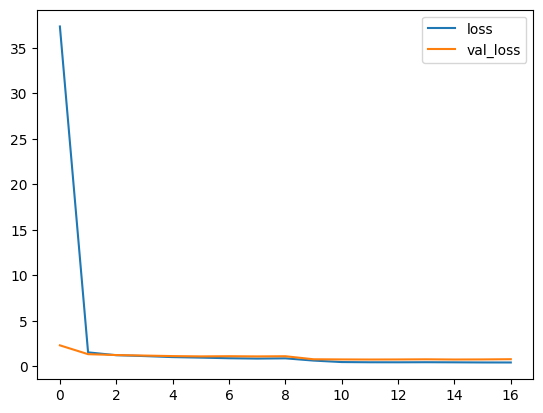

In [23]:
# Plot
plt.plot(loss, label = 'loss')
plt.plot(val_loss, label = 'val_loss')
plt.legend()
plt.show()

In [24]:
# Predictions with test data
predictions = model.predict(X_test_array)

# Extracting the labels
predictions_labels = predictions.argmax(axis = 1)

# Metrics
print('Metrics')
print(classification_report(y_test_le, predictions_labels))

# Confusion matrix
print('Confusion Matrix')
print(confusion_matrix(y_test_le, predictions_labels))

# Accuracy
print('Accuracy')
print(accuracy_score(y_test_le, predictions_labels))

63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step
Metrics
              precision    recall  f1-score   support

           0       0.89      0.78      0.83       275
           1       0.86      0.84      0.85       224
           2       0.88      0.90      0.89       695
           3       0.66      0.76      0.71       159
           4       0.88      0.90      0.89       581
           5       0.76      0.64      0.69        66

    accuracy                           0.86      2000
   macro avg       0.82      0.80      0.81      2000
weighted avg       0.86      0.86      0.86      2000

Confusion Matrix
[[214  11  14   2  33   1]
 [  5 189   9   0  16   5]
 [  4   1 623  52   9   6]
 [  2   2  25 121   8   1]
 [ 15   6  30   8 522   0]
 [  0  12   9   1   2  42]]
Accuracy
0.8555


In [70]:
# Saving the model
model.save('models/model_v1.keras')

---

## 8) Loading model

In [ ]:
# Loading the model
loaded_model = tf.keras.models.load_model('models/model_v1.keras')

# New sentence
sentence = 'I am distressed because my girlfriend is sick'

# Creating a dataframe with the sentence
df_new = pd.DataFrame({'text': [sentence]})

# Applying processing function
df_new['transformed_text'] = df_new['text'].apply(data_preprocessing)

df_new.head()

In [ ]:
# Vectorizing
df_new_tfidf = tf_idf.transform(df_new['transformed_text'])

# To array
df_new_array = df_new_tfidf.toarray()

# Previsões
prediction = loaded_model.predict(df_new_array)

# Seleciona a classe com maior probabilidade
class_prob = np.argmax(prediction, axis = 1)

# Obtém o nome da classe
class_label = le.inverse_transform(class_prob)

# Class predicted
print(f'The feeling is {class_label}')

## The End